In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [8]:
dsc_output = "/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_indep_init"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
msepkl    = os.path.join("../dsc/results", dsc_fname + "_mse.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = False

print(db)
plotprefix = "compare_elbo_rmse_linreg_indep"

/home/saikatbanerjee/scratch/work/gradvi-experiments/linreg_indep_init/linreg_indep_init.db


In [9]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [10]:
qp = dscQP(db, target, condition)
df = qp.output_table
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file
0,1,equicorrgauss,2,equicorrgauss/equicorrgauss_1,0.4,equicorrgauss/equicorrgauss_1,"(500,10000)",mr_ash,mr_ash/equicorrgauss_1_mr_ash_1
1,1,equicorrgauss,5,equicorrgauss/equicorrgauss_2,0.4,equicorrgauss/equicorrgauss_2,"(500,10000)",mr_ash,mr_ash/equicorrgauss_2_mr_ash_1
2,1,equicorrgauss,10,equicorrgauss/equicorrgauss_3,0.4,equicorrgauss/equicorrgauss_3,"(500,10000)",mr_ash,mr_ash/equicorrgauss_3_mr_ash_1
3,1,equicorrgauss,20,equicorrgauss/equicorrgauss_4,0.4,equicorrgauss/equicorrgauss_4,"(500,10000)",mr_ash,mr_ash/equicorrgauss_4_mr_ash_1
4,1,equicorrgauss,2,equicorrgauss/equicorrgauss_5,0.6,equicorrgauss/equicorrgauss_5,"(500,10000)",mr_ash,mr_ash/equicorrgauss_5_mr_ash_1
...,...,...,...,...,...,...,...,...,...
715,10,equicorrgauss,20,equicorrgauss/equicorrgauss_116,0.6,equicorrgauss/equicorrgauss_116,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/equicorrgauss_116_l...
716,10,equicorrgauss,2,equicorrgauss/equicorrgauss_117,0.8,equicorrgauss/equicorrgauss_117,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/equicorrgauss_117_l...
717,10,equicorrgauss,5,equicorrgauss/equicorrgauss_118,0.8,equicorrgauss/equicorrgauss_118,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/equicorrgauss_118_l...
718,10,equicorrgauss,10,equicorrgauss/equicorrgauss_119,0.8,equicorrgauss/equicorrgauss_119,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/equicorrgauss_119_l...


In [11]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    
def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['mse.err'].isnull()]['mse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.pve'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

In [12]:
if refresh_pickle:
    elbodf = get_elbodf(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [13]:
## remove sfix = 1
elbodf = stratify_dfcols_in_list(elbodf, "simulate.sfix", [2, 5, 10, 20])

if refresh_pickle:
    msedf = get_msedf(elbodf, dscout)
    msedf.to_pickle(msepkl)
else:
    msedf = pd.read_pickle(msepkl)

In [14]:
## Drop rows which did not converge
def filter_convergence_status(df, methods = [], remove_status = [2, 3, 4]):
    if len(methods) == 0:
        methods = [x[:-7] for x in list(df.columns) if x.endswith("_status")]
    for method in methods:
        for sidx in remove_status:
            df = df[df[f"{method}_status"] != sidx]
    return df
elbodf_filtered = filter_convergence_status(elbodf, remove_status = [2, 4])
msedf_filtered  = filter_convergence_status(msedf,  remove_status = [2, 4])
elbodf_filtered

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,gradvi_direct_lasso_init,gradvi_compound_lasso_init,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status,gradvi_direct_lasso_init_status,gradvi_compound_lasso_init_status
0,2,0.4,1,1023.360486,1023.367394,1024.077664,1023.228931,1023.415389,1023.529572,1,1,1,1,1,1
1,2,0.4,2,508.963774,508.972395,509.542860,508.585657,508.656825,508.831618,1,1,1,1,1,1
2,2,0.4,3,664.015686,664.010516,664.658667,721.279076,664.044931,664.403391,1,1,1,1,1,1
3,2,0.4,4,486.092247,486.099221,488.452399,485.830197,485.897420,486.081339,1,1,1,1,1,1
4,2,0.4,5,251.777591,251.811312,256.319928,251.078121,251.225190,251.195994,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,20,0.8,6,1218.593227,1218.591970,1219.658178,1218.434420,1218.786770,1218.946433,1,1,1,1,1,1
116,20,0.8,7,1265.415903,1265.428929,1266.261977,1265.177739,1265.322410,1265.172173,1,1,1,1,1,1
117,20,0.8,8,1249.139732,1249.147592,1249.492804,1249.008153,1249.497916,1249.422648,1,1,3,1,1,1
118,20,0.8,9,1389.374401,1389.381095,1389.670820,1389.344400,1389.464621,1389.364744,1,1,3,1,1,1


In [15]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

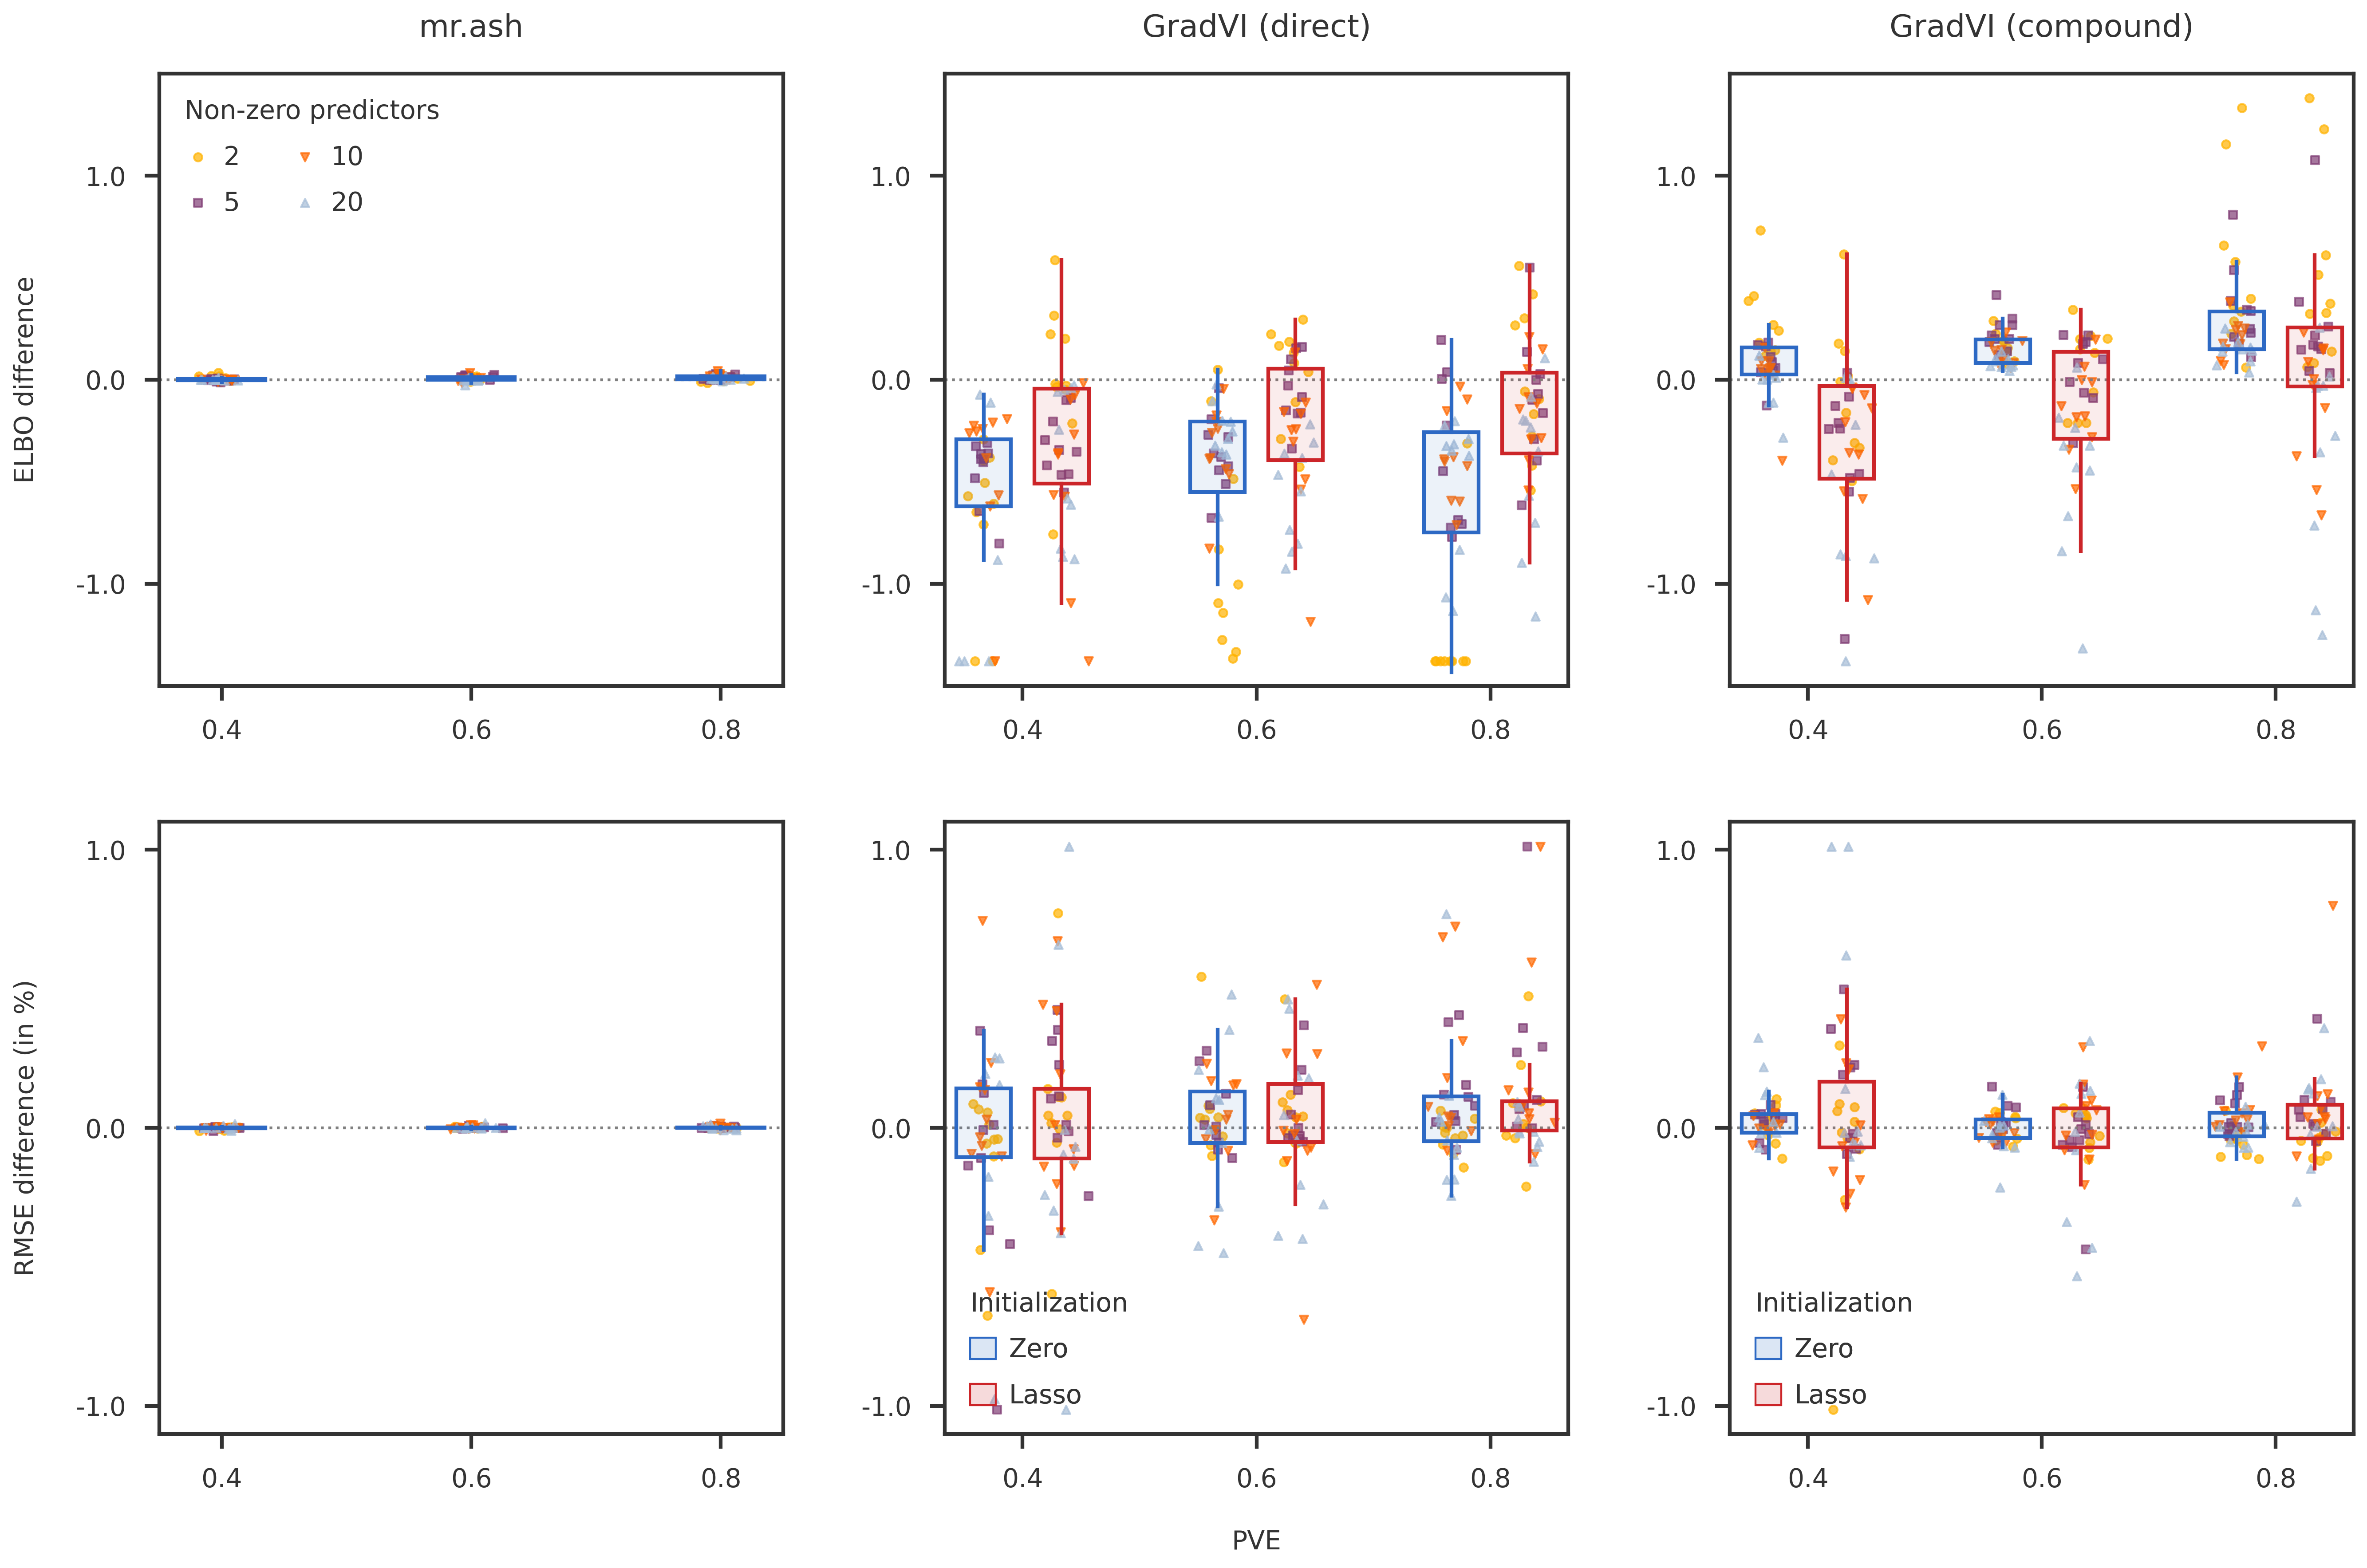

In [16]:
def np_categorize(arr):
    unq = np.unique(arr)
    d1  = {x : i for i, x in enumerate(unq)}
    d2  = {i : x for i, x in enumerate(unq)}
    return np.array([d1[x] for x in arr]), d2

def rand_jitter(arr, d = 0.02):
    stdev = d * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def truncate_jitter(arr, ylim, d = 0.04):
    xnew  = arr.copy()
    if ylim is not None:
        ydev  = d * (ylim[1] - ylim[0])
        ilow  = np.where(xnew < ylim[0] + ydev)[0]
        ihigh = np.where(xnew > ylim[1] - ydev)[0]
        if len(ilow) > 0:
            xnew[ilow]  = ylim[0] + ydev #+ np.abs(np.random.randn(len(ilow))) * ydev
        if len(ihigh) > 0:
            xnew[ihigh] = ylim[1] - ydev
    return xnew

def outlier_index(data):
    q3, q1 = np.percentile(data, [75, 25])
    iqr = q3 - q1
    xmin = q1 - 1.5 * iqr
    xmax = q3 + 1.5 * iqr
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def outlier_index_normal(data, factor = 0.9):
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    # In ANY normal distribution: IQR = Q3 - Q1 = 0.67448σ - (-0.67448σ) = 1.34896σ
    iqr_sigma = iqr / 1.34896
    median = np.median(data)
    xmin = median - factor * iqr_sigma
    xmax = median + factor * iqr_sigma
    keepidx = np.where(np.logical_and(data >= xmin, data <= xmax))
    outlieridx = np.where(np.logical_or(data < xmin, data > xmax))
    return outlieridx, keepidx

def get_outlier_index(data, factor = 10.0, keep_outliers = True):
    if keep_outliers:
        iremove = np.array([])
        ikeep   = np.arange(data.shape[0])
    else:
        iremove, ikeep = outlier_index_normal(data, factor = factor)   
    return iremove, ikeep
    

def match_index(idx1, idx2):
    return np.intersect1d(idx1, idx2, assume_unique = True)


def plot_elbo_boxplot(ax, df, reference, targets,
                      colors = None,
                      factr = 1, comparison_mode = 'absolute_diff',
                      keep_outliers = False, use_gradvi_alternate = False,
                      showboxplot = True, showscatter = True, 
                      show_boxlegend = False, show_scatterlegend = False, box_labels = list(),
                      box_legend_title = "Initialization",
                      ylim = None, debug = False):

    ref  = factr * df[reference].to_numpy()
    tgts = [factr * df[target].to_numpy() for target in targets]
    if comparison_mode == 'absolute_diff':
        diffs = [tgt - ref for tgt in tgts]
    elif comparison_mode == 'percentage_diff':
        diffs = [(tgt - ref) * 100 / np.abs(ref) for tgt in tgts]

    sfixidx, sfixvals = np_categorize(df['simulate.sfix'].to_numpy())
    pveidx,  pvevals  = np_categorize(df['simulate.pve'].to_numpy())
    
    # Colors
    if colors is None:
        colors = mpl_stylesheet.banskt_colors()
    
    # The x-axis values and labels
    ax.axhline(y = 0, linestyle = 'dotted', color = 'gray')
    if ylim is not None: ax.set_ylim(ylim)
    xvals = list(pvevals.keys())
    xlabels = list(pvevals.values())
    
    # Box plot for each PVE
    if showboxplot:
        nbox = len(targets)
        for i, target in enumerate(targets):
            boxcolor = colors[i]
            boxface = f'#{boxcolor[1:]}16' #https://stackoverflow.com/questions/15852122/hex-transparency-in-colors
            medianprops = dict(linewidth=0, color = boxcolor)
            whiskerprops = dict(linewidth=2, color = boxcolor)
            boxprops = dict(linewidth=2, color = boxcolor, facecolor = boxface)
            flierprops = dict(marker='o', markerfacecolor=boxface, markersize=3, markeredgecolor = boxcolor)
            
            # plotting data
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 5.0, keep_outliers = keep_outliers)
            positions = np.array(range(len(xvals))) * (nbox + 1) + i
            ylist = [diff[match_index(np.where(pveidx == i)[0], ikeep)] for i in xvals]
            
            # print outliers
            if debug:
                print (f"Number of outliers removed : {iremove[0].shape[0]}")
                for j in iremove[0]:
                    print(f"Index {j},\tPVE={pvevals[pveidx[j]]}, s={sfixvals[sfixidx[j]]}\t diff = {diff[j]:g}")
            # ---------------
            
            ax.boxplot(ylist, positions = positions,
                       showcaps = False, showfliers = False,
                       widths = 0.7, patch_artist = True, notch = False,
                       flierprops = flierprops, boxprops = boxprops,
                       medianprops = medianprops, whiskerprops = whiskerprops)
                
            
        label_positions = np.array(range(len(xvals))) * (nbox + 1) + (nbox - 1) / 2.0
        ax.set_xticks(label_positions)
        ax.set_xticklabels(xlabels)
        #mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear', fmt = '{:.1f}')
        mpl_utils.set_yticks(ax, scale = 'linear', spacing = 'linear')
        
        if show_boxlegend:
            #mhandles, mlabels = ax.get_legend_handles_labels()
            mhandles = list()
            mlabels  = list()
            for i, target in enumerate(targets):
                boxcolor = colors[i]
                boxface = f'#{boxcolor[1:]}16'
                mhandles.append(mpatches.Patch(facecolor = boxface, edgecolor = boxcolor))
                mlabels.append(box_labels[i])
            leg1 = ax.legend(handles = mhandles, labels = mlabels, title = box_legend_title,
                             loc = 'lower left', bbox_to_anchor = (0.02, 0.02), ncol = 1)
            leg1._legend_box.align = "left"
            ax.add_artist(leg1)

    # Scatter plot with jitter, showing sfix
    if showscatter:
        mcolors  = mpl_stylesheet.kelly_colors()
        mmarkers = ['o', 's', 'v', '^', '<', '>', 'p', 'h', 'H', 'D', 'd']
        xpve = rand_jitter(pveidx)
        
        nbox = len(targets)
        for i, target in enumerate(targets):
            diff = diffs[i]
            iremove, ikeep = get_outlier_index(diff, factor = 10.0, keep_outliers = keep_outliers)
            xpve = rand_jitter(pveidx * (nbox + 1) + i)
            
            diff_trunc = truncate_jitter(diff, ylim)
            for sidx, sfix in sfixvals.items():
                marker  = mmarkers[sidx]
                color   = mcolors[sidx]
                _idx    = np.where(sfixidx == sidx)[0]
                _ikeep  = np.intersect1d(_idx, ikeep, assume_unique = True)
                ax.scatter(xpve[_ikeep], diff_trunc[_ikeep], marker = marker, c = color,
                           alpha = 0.7, s = 20, linewidth = 1, label = f"{sfix}")
        
        # legend for number of causal predictors
        if show_scatterlegend:
            mhandles, mlabels = ax.get_legend_handles_labels()
            by_label = dict(zip(mlabels, mhandles))
            leg2 = ax.legend(handles = by_label.values(), labels = by_label.keys(), title = "Non-zero predictors",
                             loc = 'upper left', bbox_to_anchor = (0.02, 0.98), ncol = 2)
            leg2._legend_box.align = "left"


fig = plt.figure(figsize = (18, 12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

#elbo_ylim = None #[-2.1, 1.2]
elbo_ylim = [-1.5, 1.5]

#ax1.scatter(rand_jitter(pveidx), diff, alpha = 0.5)
plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["mr_ash"], show_scatterlegend = True,
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax2, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_direct", "gradvi_direct_lasso_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)
plot_elbo_boxplot(ax3, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_compound_lasso_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  keep_outliers = False, ylim = elbo_ylim)

mse_ylim = [-1.1, 1.1]
#mse_ylim = None

plot_elbo_boxplot(ax4, msedf_filtered,
                  "mr_ash_lasso_init", ["mr_ash"],
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax5, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_direct", "gradvi_direct_lasso_init"], 
                  show_boxlegend = True, box_labels = ["Zero", "Lasso"], 
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)
plot_elbo_boxplot(ax6, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_compound_lasso_init"], 
                  show_boxlegend = True, box_labels = ["Zero", "Lasso"],
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)


ax1.set_ylabel(r"ELBO difference")
ax1.set_title("mr.ash", pad = 20)
ax2.set_title("GradVI (direct)", pad = 20)
ax3.set_title("GradVI (compound)", pad = 20)
ax4.set_ylabel(r"RMSE difference (in %)")
ax5.set_xlabel("PVE")

plt.tight_layout(w_pad = 3.0, h_pad = 3.0)
#utils.saveplot(fig, plotprefix)
plt.show()

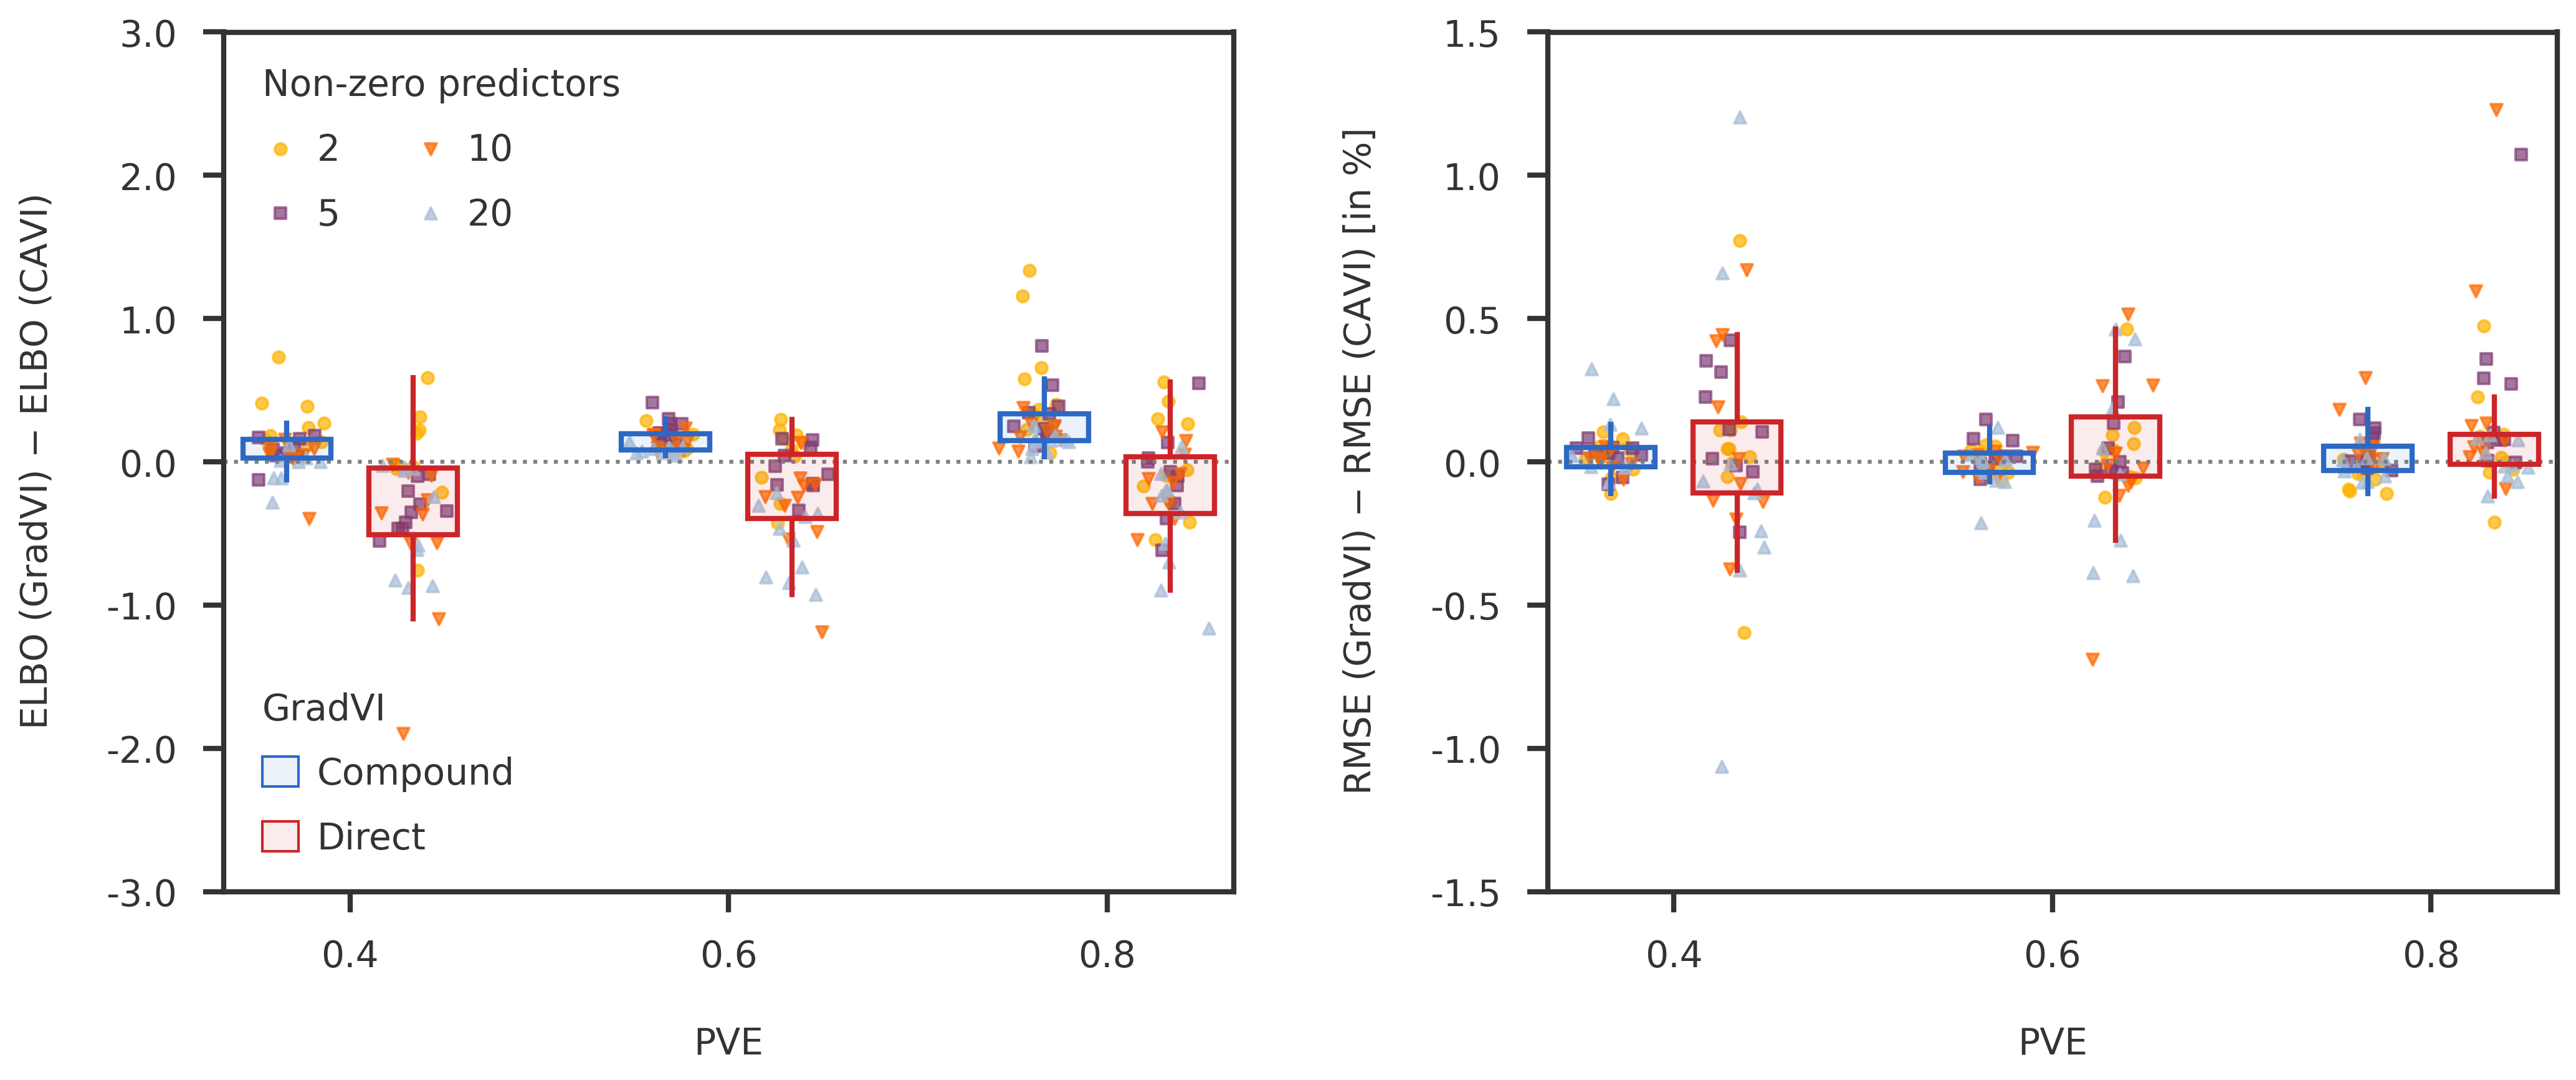

In [18]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

elbo_ylim = [-3, 3]
mse_ylim = [-1.5, 1.5]

plot_elbo_boxplot(ax1, elbodf_filtered, 
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_direct_lasso_init"],
                  comparison_mode = 'absolute_diff', factr = -1,
                  show_scatterlegend = True,
                  show_boxlegend = True, box_labels = ["Compound", "Direct"], 
                  box_legend_title = "GradVI",
                  keep_outliers = False, ylim = elbo_ylim)

plot_elbo_boxplot(ax2, msedf_filtered,
                  "mr_ash_lasso_init", ["gradvi_compound", "gradvi_direct_lasso_init"], 
                  show_boxlegend = False, 
                  comparison_mode = 'percentage_diff',
                  keep_outliers = False, ylim = mse_ylim)

ax1.set_ylabel(r"ELBO (GradVI) $-$ ELBO (CAVI)")
ax2.set_ylabel(r"RMSE (GradVI) $-$ RMSE (CAVI) [in %]")
ax1.set_xlabel("PVE")
ax2.set_xlabel("PVE")

mpl_utils.set_yticks(ax1, kmin = 4, kmax = 10)
mpl_utils.set_yticks(ax2, kmin = 4, kmax = 10)

plt.tight_layout(w_pad = 3.0)
utils.saveplot(fig, "gradvi_linreg_indep_converge_to_cavi")
plt.show()